# 第6章_b 應用預訓練模型辨識影像

**列表6.12  在Jupyter Notebook顯示圖表**

In [1]:
%matplotlib inline

**列表6.13  確認模型的概要**

In [2]:
from tensorflow.python.keras.applications.vgg16 import VGG16


# 不使用現有的1000個類別的輸出層
# 設定include_top=False，於未納入輸出層的狀態載入模型
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# 確認模型的概要，可發現的確未納入輸出層
vgg16.summary()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


58892288/58889256 [==============================]58892288/58889256 [==============================] - 17s 0us/step

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________

**列表6.14  利用VGG16建置模型以及設定學習方法**

In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten


# 編輯模型，定義產生神經網路的函數
def build_transfer_model(vgg16):
    
    # 利用載入的模型建置新模型
    model = Sequential(vgg16.layers)

    # 將載入的局部權重設定，以便不重新學習
    # 這次只學習新增層與接近輸出層的層的權重
    for layer in model.layers[:15]:
        layer.trainable = False

    # 建置新增的輸出層
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# 呼叫定義的函數，建置神經網路
model = build_transfer_model(vgg16)

**列表6.15  指定最佳化演算法與編譯模型**

In [4]:
from tensorflow.python.keras.optimizers import SGD


model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
# 確認模型的概要
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

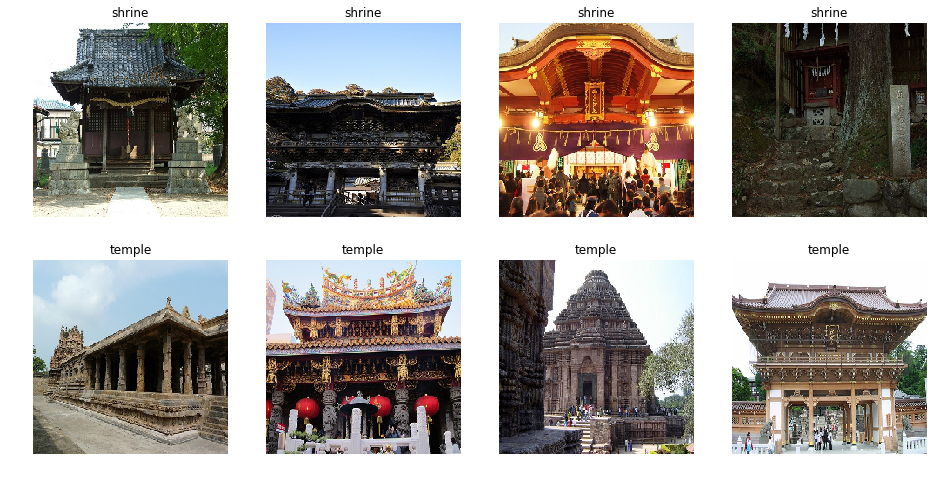

In [6]:
from utils import show_train_samples


# 隨機顯示學習專用資料的內容
img_dir = 'img/shrine_temple'
show_train_samples(img_dir, classes=('shrine', 'temple'), seed=1)

**列表6.16  建置產生器**

In [7]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import preprocess_input


# 建置載入學習專用影像的產生器，指定尺度轉換與資料擴充的參數
idg_train = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

**列表6.17  產生迭代器**　

In [8]:
# 建置載入影像的迭代器

# 訓練資料（用於學習之際）
img_itr_train = idg_train.flow_from_directory(
    'img/shrine_temple/train', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

# 檢測資料（用於學習之際）
img_itr_validation = idg_train.flow_from_directory(
    'img/shrine_temple/validation', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


**列表6.18  建立儲存模型的資料夾**

In [9]:
import os
from datetime import datetime


# 建立儲存模型的資料夾
model_dir = os.path.join(
    'models', 
    datetime.now().strftime('%y%m%d_%H%M')
)
os.makedirs(model_dir, exist_ok=True)
print('model_dir:', model_dir)  # 顯示儲存模型的資料夾的名稱

dir_weights = os.path.join(model_dir, 'weights')
os.makedirs(dir_weights, exist_ok=True)

model_dir: models/180411_1321


**列表6.19  儲存神經網路與類別標籤**

In [11]:
import json
import pickle


# 儲存神經網路
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w') as f:
    json.dump(model.to_json(), f)

# 儲存學習之際的正確解答標籤
model_classes = os.path.join(model_dir, 'classes.pkl')
with open(model_classes, 'wb') as f:
    pickle.dump(img_itr_train.class_indices, f)

**列表6.20  計算學習幾個小批次算是1個時期**

In [12]:
import math


# 計算幾個批次學習算是1個時期（因為得於學習之際指定這個值）
batch_size = 16
steps_per_epoch = math.ceil(
    img_itr_train.samples/batch_size
)
validation_steps = math.ceil(
    img_itr_validation.samples/batch_size
)

**列表6.21  產生與設定Callback**

In [10]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger


# Callbacks的設定
cp_filepath =  os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
                     cp_filepath, 
                     monitor='loss', 
                     verbose=0,
                     save_best_only=False, 
                     save_weights_only=True, 
                     mode='auto', 
                     period=5
                     )

csv_filepath =  os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

**列表6.22  學習模型**

In [13]:
n_epoch = 30

# 學習模型
history = model.fit_generator(
    img_itr_train, 
    steps_per_epoch=steps_per_epoch, 
    epochs=n_epoch,  # 學習的時期數
    validation_data=img_itr_validation, 
    validation_steps=validation_steps,
    callbacks = [cp, csv]
)

Epoch 1/30
38/38 [==============================]38/38 [==============================] - 15s 384ms/step - loss: 0.6851 - acc: 0.6086 - val_loss: 0.4399 - val_acc: 0.8750

Epoch 2/30
38/38 [==============================]38/38 [==============================] - 12s 326ms/step - loss: 0.4333 - acc: 0.8059 - val_loss: 0.3233 - val_acc: 0.8900

Epoch 3/30
38/38 [==============================]38/38 [==============================] - 12s 323ms/step - loss: 0.3874 - acc: 0.8372 - val_loss: 0.2474 - val_acc: 0.9300

Epoch 4/30
38/38 [==============================]38/38 [==============================] - 12s 323ms/step - loss: 0.3543 - acc: 0.8602 - val_loss: 0.2599 - val_acc: 0.8950

Epoch 5/30
38/38 [==============================]38/38 [==============================] - 12s 328ms/step - loss: 0.3093 - acc: 0.8849 - val_loss: 0.2282 - val_acc: 0.9100

Epoch 6/30
38/38 [==============================]38/38 [==============================] - 12s 323ms/step - loss: 0.2913 - acc: 0.8684 - val_

**列表6.23  使用學習所得的模型預測** 

In [14]:
from utils import load_random_imgs

# 計算預測結果（推測）
test_data_dir = 'img/shrine_temple/test/unknown'
x_test, true_labels = load_random_imgs(
    test_data_dir, 
    seed=1
)
x_test_preproc= preprocess_input(x_test.copy())/255.
probs = model.predict(x_test_preproc)

probs

array([[0.9999937 ],
       [0.99982363],
       [0.04902444],
       [0.02410024],
       [0.01623353],
       [0.02889599],
       [0.9998658 ],
       [0.9999567 ]], dtype=float32)

In [15]:
# 確認類別標籤
print('class_indices:', img_itr_train.class_indices)

class_indices: {'temple': 1, 'shrine': 0}


**列表6.24  評估結果**

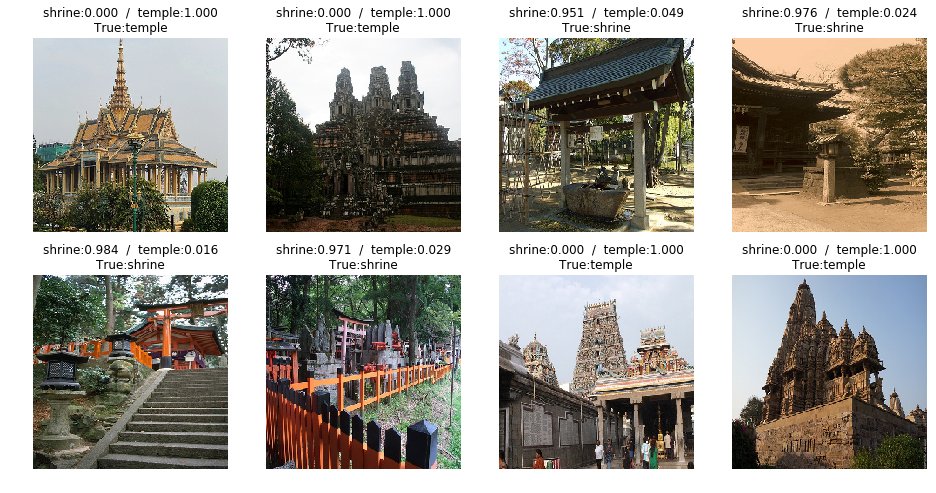

In [16]:
from utils import show_test_samples


# 顯示評估所用的影像
show_test_samples(
    x_test, probs, 
    img_itr_train.class_indices, 
    true_labels
)

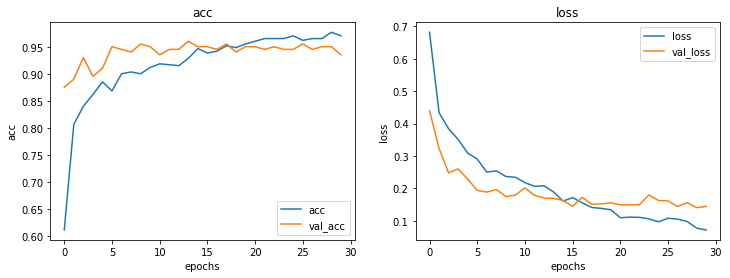

In [17]:
from utils import plot_learningcurve_from_csv


# 顯示學習曲線
plot_learningcurve_from_csv(csv_filepath)